# Segmentation Metrics

In this numerical example, we will look at different metrics which can be used for image segmentation problems.

## Imports

Let's start by importing the python modules which we will need.

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import Markdown, display

from matplotlib import pyplot as plt

import numpy as np

import metrics

# Dummy Example

We will begin by defining a dummy data point.
Consider a binary `0`/`1` pixel-wise segmentation problem, with image dimension $256 \times 256$.

The ground truth will be a rectangle of size $120 \times 80$, while the "predicted" mask will be of the same size, only offset by $(-30, -30)$.
Let's plot this scenario:

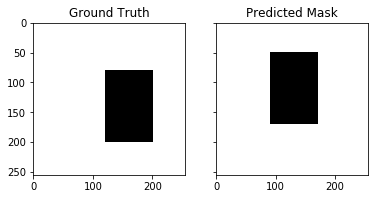

In [2]:
MASK_WIDTH, MASK_HEIGHT = 256, 256
NUM_CLASSES = 1

y_true = np.zeros(shape=(MASK_HEIGHT, MASK_WIDTH, NUM_CLASSES), dtype="uint8")
y_pred = np.zeros(shape=(MASK_HEIGHT, MASK_WIDTH, NUM_CLASSES), dtype="uint8")

y_true[80:200, 120:200] = 1
y_pred[50:170, 90:170] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.set_title("Ground Truth")
ax2.set_title("Predicted Mask")

ax1.imshow(np.squeeze(y_true), cmap="binary");
ax2.imshow(np.squeeze(y_pred), cmap="binary");

Some pixels have been correctly classified, while others have not, both by predicting `0`, when really `1` is the case, and vice versa.

## True/False Positives/Negatives

For ground truths in classification problems, we have the following definitions:

* **Condition Positive (P)** - Number of class $A$ in the data.
* **Condition Negative (N)** - Number of class $A^C$ in the data.

Where $A^C$ denotes the class complement of $A$, i.e. all other classes besides class $A$.
In our binary classification problem $A$ denotes `1` and $A^C$ denotes `0`.

The conditions are easily calculated as:

In [3]:
%psource metrics.conditions

def conditions(y_true: np.ndarray) -> Tuple[int, int]:
    positives = int(np.sum(y_true))
    negatives = y_true.size - positives
    return positives, negatives


In [4]:
P, N = metrics.conditions(y_true=y_true)
print(f"P = {P}")
print(f"N = {N}")

P = 9600
N = 55936


Four related concepts need also be defined:

* **True Positive (TP)** - Class $A$ correctly predicted as $A$ (correctly identified).
* **True Negative (TN)** - Class $A^C$ correctly predicted as $A^C$ (correctly rejected).

* **False Positive (FP)** - $A^C$ wrongly predicted as $A$ (incorrectly identified).
* **False Negative (FN)** - $A$ wrongly predicted as $A^C$ (incorrectly rejected).

False positves (FP) are often knows as _type I errors_ in statistics, and false negatives (FN) as _Type II errors_.
The greater the values of TP and TN, the better, and the smaller the values of FP and FN, the better. We will collectively refer to these four values as _confusions_, for a lack of a better name.

These metrics will also be implemented now:

In [5]:
%psource metrics.confusions

def confusions(
    y_pred: np.ndarray,
    y_true: np.ndarray,
) -> Tuple[int, int, int, int]:
    tp = int(np.logical_and(y_pred == 1, y_true == 1).sum())
    tn = int(np.logical_and(y_pred == 0, y_true == 0).sum())
    fp = int(np.logical_and(y_pred == 1, y_true == 0).sum())
    fn = int(np.logical_and(y_pred == 0, y_true == 1).sum())
    return tp, tn, fp, fn


In [6]:
confusions = metrics.confusions(y_true=y_true, y_pred=y_pred)
for name, metric in zip("TP TN FP FN".split(), confusions):
    display(Markdown(f"* **{name}** = {metric}"))

* **TP** = 4500

* **TN** = 50836

* **FP** = 5100

* **FN** = 5100

In pixel-wise segmentation tasks, every single pixel in the predicted mask will be labeled as one of these four categories (FP, TN, FP, FN).

We can therefore plot these labels in order to get a more intuitive picture of how these labels are distributed in practice.
The following function does exactly this.

In [7]:
%psource metrics.plot_conditions

def plot_conditions(
    y_pred: np.ndarray,
    y_true: np.ndarray,
    cutoff: float = 0.5,
) -> None:
    y_pred = np.squeeze(y_pred)
    y_true = np.squeeze(y_true)

    predicted_mask = (y_pred > cutoff).astype("uint8")
    tp = np.logical_and(predicted_mask == 1, y_true == 1)
    tn = np.logical_and(predicted_mask == 0, y_true == 0)
    fp = np.logical_and(predicted_mask == 1, y_true == 0)
    fn = np.logical_and(predicted_mask == 0, y_true == 1)
    confusion_matrix = tp + 2 * tn + 3 * fp + 4 * fn

    cmap = colors.ListedColormap(
        ['#001F3F', '#DDDDDD', '#2ECC40', '#FF4136']
    )
    bounds = [0, 1.5, 2.5, 3.5, 5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(1, 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.imshow(confusion_matrix, cmap=cmap, norm=norm)

    # Add TP/TN/FP/FN legend to plot
    legend_elements = [
        Patch(facecolor='#001F3F', edgecolor="white", label='TP'),
        Patch(faceco

Let's try this on our dummy problem.

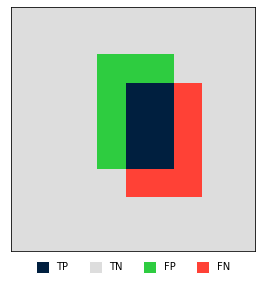

In [8]:
metrics.plot_conditions(y_pred=y_pred, y_true=y_true)

A more more numerical, and less spatial, representation of the prevalence of each label type is the so-called _confusion matrix_.
It shows the values of TP, TN, FP, and FN in tabular form.
Let's implement this:

In [9]:
%psource metrics.confusion_matrix

def confusion_matrix(
    y_pred: np.ndarray,
    y_true: np.ndarray,
) -> Tuple[int, int, int, int]:
    tp, tn, fp, fn = confusions(y_pred=y_pred, y_true=y_true)
    return pd.DataFrame(
        data=[[tp, fp], [fn, tn]],
        index=["Positive Prediction", "Negative Prediction"],
        columns=["Condition Positive", "Condition Negative"],
    )


In [10]:
metrics.confusion_matrix(y_pred=y_pred, y_true=y_true)

,Condition Positive,Condition Negative
Positive Prediction,4500,5100
Negative Prediction,5100,50836


## Sensitivity and Specificity

One of the issues with the confusion metrics, is that it is not _sample size invariant_.
With other words, it is not straight forward to compare two confusion matrices when the metrics have been calculated of two datasets of different size. The concepts of _sensitivity_ and _specificity_ helps with this comparison problem:

\begin{align*}
    \textbf{sensitivity}
    &=
    \frac{\text{number of true positives}}{\text{number of true positives + number of false negatives}}
    =
    \frac{TP}{TP + FN}
    =
    \frac{TP}{P}
    \\
    \textbf{specificity}
    &=
    \frac{\text{number of true negatives}}{\text{number of true negatives + number of false positives}}
    =
    \frac{TN}{TN + FP}
    =
    \frac{TN}{N}
\end{align*}

The _sensitivity_ is therefore a measure of how good the given model prediction was able to identify positives as a relative, frational value.
Likewise, the _specificity_ is a measure of how good the given model prediction was able to identify negatives as a relative, fractional value.

We will now implement these metrics:

In [11]:
%psource metrics.sensitivity_and_specificity

def sensitivity_and_specificity(
    y_pred: np.ndarray,
    y_true: np.ndarray,
) -> Tuple[float, float]:
    tp, tn, fp, fn = confusions(y_pred=y_pred, y_true=y_true)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity


In [12]:
sensitivity, specificity = metrics.sensitivity_and_specificity(
    y_pred=y_pred,
    y_true=y_true,
)
display(Markdown(f"* **sensitivity** = {100 * sensitivity:.2f}%"))
display(Markdown(f"* **specificity** = {100 * specificity:.2f}%"))

* **sensitivity** = 46.88%

* **specificity** = 90.88%

We can see, that for the given dummy problem, the prediction is "much better" at identifying negatives compared to positives.
This comes as no surprise, given the larger amount of negatives and how the dummy problem is constructed.

## Pixel Accuracy

A more naive metric for semantic segmentation problems is the _pixel accuracy_.
This metric simply reports the percentage of pixels that were correctly classified.
More formally, it can be defined as:

$$
    \textbf{accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{TP + TN}{P + N}
$$

This metric will now be implemented and evaluated:

In [13]:
%psource metrics.accuracy

def accuracy(
    y_pred: np.ndarray,
    y_true: np.ndarray,
) -> Tuple[int, int]:
    tp, tn, fp, fn = confusions(y_pred=y_pred, y_true=y_true)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return accuracy


In [14]:
accuracy = metrics.accuracy(y_true=y_true, y_pred=y_pred)
display(Markdown(f"**accuracy** = {100 * accuracy:.2f}%"))

**accuracy** = 84.44%

The problem with pixel-wise accuracy metrics is that it does not account for class inbalances.
Consider a problem where 95% of all pixels are considered to be of class `0`, and the remaining 5% of class `1`.
If we construct a model which predicts `0.0` regardless of the fiture inputs provided to the model, the model will achieve a 95% accuracy score.
Generally, a model which predicts always predicts `0` on a test set with class balance $\alpha / (1 - \alpha)$ will achieve a pixel-wise accuracy score of $\alpha$.

This makes pixel-wise accuracy scores basically useless when you do not know the class balance of the underlying dataset and the actual predictions across the classes.
This is why it is often replaced by other metrics which takes inbalances and model confidence into account.

Write about other metrics as explained [here](https://www.jeremyjordan.me/evaluating-image-segmentation-models/).

### The Intersection over Union (IoU) Metric

A more commonly used metric for segmentation metrics is the intersection over union metric.
It is defined as follows:

$$
    \mathrm{IoU}
    =
    \frac{\mathrm{target} \cap \mathrm{prediction}}{\mathrm{target} \cup \mathrm{prediction}}
    =
    \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP} + \mathrm{FN}}
$$

The implementation in form of code is as follows:

In [18]:
%psource metrics.iou

def iou(
    y_pred: np.ndarray,
    y_true: np.ndarray,
) -> Tuple[int, int]:
    tp, tn, fp, fn = confusions(y_pred=y_pred, y_true=y_true)
    iou = tp / (tp + fp + fn)
    return iou


And again, we will evaluate this metric on our dummy problem:

In [19]:
iou = metrics.iou(y_true=y_true, y_pred=y_pred)
display(Markdown(f"**IoU** = {iou}"))

**IoU** = 0.30612244897959184

As you can see, this metric captures the fact that our prediction is quite sub-optimal.
The IoU metric's range is $[0, 1]$ inclusive, where `0` indicates that no positive case has been correctly classified at all, and `1` indicates perfect overlap between predicted mask and ground truth mask.

This metric is much more balanced.
In the case where there are no positive conditions in the ground truth, $\mathrm{TP} \equiv 0$ and $\mathrm{IoU} \equiv 0$, by definition.
So $\mathrm{IoU}$ will become zero for the given positive class _even_ if the predicted mask is perfectly consistent with the ground truth.
In such cases it is common to define $\mathrm{IoU} = 1$ if $\mathrm{P} = 0$.
The drawback of this approach is that the metric will not capture false positives.

In the case of multiple classes, you calculate one IoU metric for each class and average across the classes. This is called mean IoU, and can be used to remedy the problem mentioned in the previous paragraph.